# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.303849
sanity check: 2.302585


In [20]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.146487 analytic: 1.146487, relative error: 3.419945e-08
numerical: -1.046278 analytic: -1.046278, relative error: 4.614021e-08
numerical: -6.047666 analytic: -6.047667, relative error: 2.165036e-09
numerical: 5.826794 analytic: 5.826794, relative error: 2.009450e-08
numerical: -3.270227 analytic: -3.270227, relative error: 9.553204e-09
numerical: 0.709763 analytic: 0.709763, relative error: 7.064689e-08
numerical: -1.265497 analytic: -1.265497, relative error: 1.549759e-08
numerical: -2.211140 analytic: -2.211140, relative error: 2.811984e-08
numerical: 2.884851 analytic: 2.884851, relative error: 1.546130e-08
numerical: 2.322579 analytic: 2.322578, relative error: 3.574508e-08
numerical: 3.067228 analytic: 3.061713, relative error: 8.998271e-04
numerical: -1.233819 analytic: -1.230469, relative error: 1.359407e-03
numerical: -0.071908 analytic: -0.093199, relative error: 1.289500e-01
numerical: 2.070190 analytic: 2.071580, relative error: 3.355648e-04
numerical: 0.772071 

## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [21]:
from cs231n.classifiers.softmax import softmax_loss_vectorized

loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 0.0)

f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

loss, grad = softmax_loss_vectorized(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_vectorized(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.788884 analytic: 1.788884, relative error: 1.657308e-08
numerical: 1.338251 analytic: 1.338251, relative error: 3.739017e-08
numerical: 0.233057 analytic: 0.233057, relative error: 1.189247e-07
numerical: 2.921272 analytic: 2.921272, relative error: 8.141799e-09
numerical: 2.337571 analytic: 2.337571, relative error: 2.850122e-08
numerical: -3.323627 analytic: -3.323628, relative error: 9.151787e-09
numerical: -3.509228 analytic: -3.509228, relative error: 5.329841e-09
numerical: 1.712747 analytic: 1.712747, relative error: 2.259396e-08
numerical: -1.846928 analytic: -1.846928, relative error: 9.168721e-09
numerical: -1.474616 analytic: -1.474616, relative error: 1.289572e-08
numerical: 4.413775 analytic: 4.400910, relative error: 1.459581e-03
numerical: 0.210047 analytic: 0.228803, relative error: 4.273941e-02
numerical: -0.321464 analytic: -0.327125, relative error: 8.728827e-03
numerical: 2.657592 analytic: 2.660293, relative error: 5.079134e-04
numerical: 0.941582 anal

In [22]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.303849e+00 computed in 0.472634s
vectorized loss: 2.303849e+00 computed in 0.015044s
Loss difference: 0.000000
Gradient difference: 0.000000


In [23]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

for lr in learning_rates:
    for rs in regularization_strengths:
        smax = Softmax()
        loss_hist = smax.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=1500, verbose=True)
        y_train_pred = smax.predict(X_train)
        y_val_pred = smax.predict(X_val)
        results[(lr,rs)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
best_val = sorted(results.items(), key=lambda v: v[1])[-1][0]
print best_val

print 'best validation accuracy achieved during cross-validation:', best_val

iteration 0 / 1500: loss 768.733930
iteration 100 / 1500: loss 761.970889
iteration 200 / 1500: loss 756.609503
iteration 300 / 1500: loss 751.779018
iteration 400 / 1500: loss 746.849910
iteration 500 / 1500: loss 742.142273
iteration 600 / 1500: loss 737.477114
iteration 700 / 1500: loss 733.036767
iteration 800 / 1500: loss 728.837776
iteration 900 / 1500: loss 724.677396
iteration 1000 / 1500: loss 720.468184
iteration 1100 / 1500: loss 715.754091
iteration 1200 / 1500: loss 711.493504
iteration 1300 / 1500: loss 707.578768
iteration 1400 / 1500: loss 703.851276
iteration 0 / 1500: loss 1518299.062595
iteration 100 / 1500: loss 66.645525
iteration 200 / 1500: loss 13.644387
iteration 300 / 1500: loss 14.516829
iteration 400 / 1500: loss 13.910719
iteration 500 / 1500: loss 13.881225
iteration 600 / 1500: loss 14.265329
iteration 700 / 1500: loss 13.937094
iteration 800 / 1500: loss 14.027924
iteration 900 / 1500: loss 13.602018
iteration 1000 / 1500: loss 14.056439
iteration 1100 /

TypeError: not all arguments converted during string formatting

In [24]:
# evaluate on test set
# Evaluate the best softmax on test set

best_softmax = Softmax()
loss_hist = best_softmax.train(X_train, y_train, learning_rate=best_val[0], reg=best_val[1],
                               num_iters=1500, verbose=True)
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

iteration 0 / 1500: loss 783.289554
iteration 100 / 1500: loss 755.331072
iteration 200 / 1500: loss 733.153677
iteration 300 / 1500: loss 712.313152
iteration 400 / 1500: loss 692.660160
iteration 500 / 1500: loss 673.420643
iteration 600 / 1500: loss 655.205787
iteration 700 / 1500: loss 637.840896
iteration 800 / 1500: loss 620.602508
iteration 900 / 1500: loss 604.330842
iteration 1000 / 1500: loss 588.255430
iteration 1100 / 1500: loss 573.278530
iteration 1200 / 1500: loss 557.580850
iteration 1300 / 1500: loss 543.680655
iteration 1400 / 1500: loss 529.296467
softmax on raw pixels final test set accuracy: 0.359000


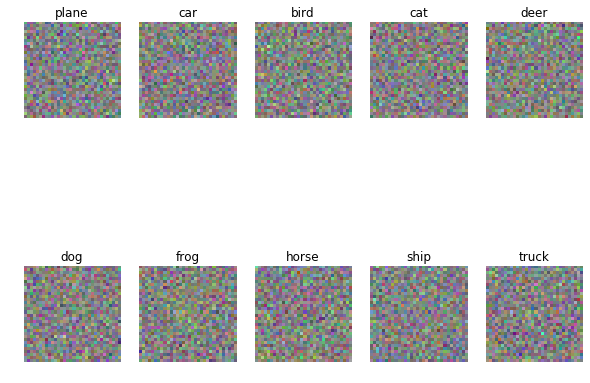

In [25]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])